<a href="https://colab.research.google.com/github/fabb91/mlsamples/blob/main/X-RAY-chest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook I will present some of the results of my first attempts at implementing a deep learning model to solve a computer vision problem, I'm still far from being an expert of the field and my intention here is not to compete with other kernels, instead I'm just trying to break the ice with Deep Learning and the (awesome) Kaggle community while learning as much Data Science as possible.

Having little to no previous experience in this field, I followed as an example for my analysis the current top kernel for this dataset, made by the user NAIN (please check out his awesome work if you haven't already: https://www.kaggle.com/aakashnain/beating-everything-with-depthwise-convolution, thank you NAIN for all the things you taught me, hopefully one day my notebooks will be as helpful and useful to other people) so you can see some of his code here especially for mechanical things like loading the images from disk and plotting the confusion matrix, though many more things are different and I reached different results that I think are worth to be shown.

I made this notebook using Google Colab and Google Drive, I did a lot of trial and error attempts there, now I'm publishing here the final results.

In [ ]:
#load data directories
dir='/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/'

test='/kaggle/input/chest-xray-pneumonia/chest_xray/test'
train='/kaggle/input/chest-xray-pneumonia/chest_xray/train'
val='/kaggle/input/chest-xray-pneumonia/chest_xray/val'

norm_test='/kaggle/input/chest-xray-pneumonia/chest_xray/test/NORMAL'
pneum_test='/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA'

norm_train='/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL'
pneum_train='/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA'

norm_val='/kaggle/input/chest-xray-pneumonia/chest_xray/val/NORMAL'
pneum_val='/kaggle/input/chest-xray-pneumonia/chest_xray/val/PNEUMONIA'

In [ ]:
import pandas as pd
from pathlib import Path

In [ ]:
#Load train dataset
train_data_norm=pd.DataFrame(Path(norm_train).glob('*.jpeg'))
train_data_pneum=pd.DataFrame(Path(pneum_train).glob('*.jpeg'))

train_data_norm[1]=0
train_data_pneum[1]=1

train_data=train_data_norm.append(train_data_pneum)

In [ ]:
#Load test dataset
test_data_norm=pd.DataFrame(Path(norm_test).glob('*.jpeg'))
test_data_pneum=pd.DataFrame(Path(pneum_test).glob('*.jpeg'))

test_data_norm[1]=0
test_data_pneum[1]=1

test_data=test_data_norm.append(test_data_pneum)

In [ ]:
#Load validation dataset
val_data_norm=pd.DataFrame(Path(norm_val).glob('*.jpeg'))
val_data_pneum=pd.DataFrame(Path(pneum_val).glob('*.jpeg'))

val_data_norm[1]=0
val_data_pneum[1]=1

val_data=val_data_norm.append(val_data_pneum)

In [ ]:
#Let's explore the data
count_tr=len(train_data)
count_tr_n=len(train_data[train_data[1]==0])
count_tr_p=len(train_data[train_data[1]==1])

count_ts=len(test_data)
count_ts_n=len(test_data[test_data[1]==0])
count_ts_p=len(test_data[test_data[1]==1])

count_val=len(val_data)
count_val_n=len(val_data[val_data[1]==0])
count_val_p=len(val_data[val_data[1]==1])

In [ ]:
print('Train data')

print(f'Normal cases    {count_tr_n}   ({round(count_tr_n/count_tr,2)*100}%)')
print(f'Pneunomia cases {count_tr_p}   ({round(count_tr_p/count_tr,2)*100}%)')
print(f'Total cases:    {count_tr} ')
print('')
print('Test data')
print(f'Normal cases    {count_ts_n}   ({round(count_ts_n/count_ts,2)*100}%)')
print(f'Pneunomia cases {count_ts_p}   ({round(count_ts_p/count_ts,2)*100}%)')
print(f'Total cases:    {count_ts} ')
print('')
print('Validation data')
print(f'Normal cases    {count_val_n}   ({round(count_val_n/count_val,2)*100}%)')
print(f'Pneunomia cases {count_val_p}   ({round(count_val_p/count_val,2)*100}%)')
print(f'Total cases:    {count_val} ')

Train data
Normal cases    1341   (26.0%)
Pneunomia cases 3875   (74.0%)
Total cases:    5216 

Test data
Normal cases    234   (38.0%)
Pneunomia cases 390   (62.0%)
Total cases:    624 

Validation data
Normal cases    8   (50.0%)
Pneunomia cases 8   (50.0%)
Total cases:    16 


Classes are not balanced, the classifier could naively learn to simply classify every image as a Pneunomia case and still get 62% precision at test time, this is a danger signal.

Images come from a folder for each class, which means they're ordered by group and in this case it's good practice to shuffle the data.

In [ ]:
# Let's shuffle the data
from sklearn.utils import shuffle

In [ ]:
train_data =shuffle(train_data)
test_data = shuffle(test_data)
val_data = shuffle(val_data)

Let's load and resize the data:

This part was pretty much  copy-pasted from NAIN's notebook (sorry about that), I do have a couple of comments to make though:

1) I added the blackwhite_counter to see if there actually were any black and white images, and to my knowledge there were none.
Maybe this control is just a good practice that we're supposed to make on a dataset of images.

2) It wasn't clear to me why we were converting from BGR to RGB [cv2.cvtColor(img, cv2.COLOR_BGR2RGB)], in case you're also wondering, know that it's because apparenty the cv2.imread() function automatically loads images in the BGR format and we need them to be in the RGB format.


I saved the shapes of the images just for personal curiosity, I wanted to see what were the real shapes were, I've had no real use for them in this notebook. 
(you can skip them)

Let's load the images.

In [ ]:
import cv2
import numpy as np

In [ ]:
#loading train data
train_img = []
train_label = []
train_shapes =[]
blacwhite_counter=0
for i, imgfile in enumerate(train_data[0]):
    img = cv2.imread(str(imgfile))
    train_shapes.append(np.shape(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
        blacwhite_counter= blacwhite_counter+1
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    train_img.append(img)
    train_label.append(train_data.iloc[i,1])


In [ ]:
#loading test data
test_img = []
test_label = []
test_shapes=[]
blacwhite_counter_t=0
for i, imgfile in enumerate(test_data[0]):
    img = cv2.imread(str(imgfile))
    test_shapes.append(np.shape(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
        blacwhite_counter_t= blacwhite_counter_t+1
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    test_img.append(img)
    test_label.append(test_data.iloc[i,1])

In [ ]:
#loading val data
val_img = []
val_label = []
val_shapes=[]
blacwhite_counter_v=0
for i, imgfile in enumerate(val_data[0]):
    img = cv2.imread(str(imgfile))
    val_shapes.append(np.shape(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
      img = np.dstack([img, img, img])
      blacwhite_counter_v= blacwhite_counter_v+1
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    val_img.append(img)
    val_label.append(val_data.iloc[i,1])


In [ ]:
print(blacwhite_counter, blacwhite_counter_t,blacwhite_counter_v)

0 0 0


In [ ]:
from keras.utils import to_categorical

Using TensorFlow backend.


In [ ]:
#I rename the datasets with easier names and turn the labels into categorical data
trainX = np.array(train_img)
trainY = to_categorical(np.array(train_label))
valX = np.array(val_img)
valY = to_categorical(np.array(val_label))
testX = np.array(test_img)
testY = to_categorical(np.array(test_label))

In [ ]:
# You can delete the old variables to clean some ram
del train_img, train_label, val_img, val_label, test_img, test_label

Now we're finally ready to build some cool Neural Networks.

I'll start with the image augmentation generator, and I'll plot some examples of the images generated so we know what input we are actually feeding to the model, since I noticed that blindly setting augmentation parameters can give very bad results and unexpected surprises.

When defining the generator, you can see the list of the most common augmentations we can apply to our images.

Of these I personally noticed that shifting and rotating actually gave very bad results, maybe if you're using fine-tuning on networks already trained on this kind of augmentation they might give better results, but from the many experiments I did with the neural networks I built from scratch I found no improvement whatsoever and they simply slowed down and disrupted the training process.

I think this might even be logical for our data since we're analyzing Xray images which usually have a fixed orientation and there's not much sense in rotating an Xray picture, they usually all have the same orientation and position.

Of the remaining augmentation options:
  -brightness_range -> I had to remove it because it seemed to not function well and it broke the images. (see example below)

  -horizontal_flip -> didn't seem to cause much trouble but didn't show any improvements either.

So I ended up using only zoom_range, which surprisingly seemed to be more than enough.

Just for curiosity here's what the brightness augmentation did to my data.

I tried all kinds of brightness ranges, couldn't seem to get it to generate any usable image.

I'd have to use offline augmentation and basically create a new dataset with the manually augmented images added to the original ones, maybe I could try it in the future.

In [ ]:
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

from keras.layers import GaussianNoise
from keras.layers import Activation
import keras.metrics
from sklearn.metrics import precision_score , recall_score

from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

from sklearn.metrics import classification_report

import matplotlib.pyplot as plt

In [ ]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator(#zoom_range=[0.9,1.1],
                         brightness_range=[0.9,1.1]
                         #horizontal_flip=True ,
                         #rotation_range=90,
                         #height_shift_range=0.15,
                         #width_shift_range=[-0.125,0.125]
                         )

aug.fit(trainX)

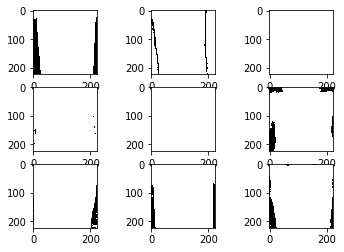

In [ ]:
for X_batch, y_batch in aug.flow(trainX, trainY, batch_size=9):
	# create a grid of 3x3 images
	for i in range(0, 9):
		plt.subplot(330 + 1 + i)
		plt.imshow(X_batch[i])
	# show the plot
	plt.show()
	break

Sadly I can't seem to be able to make brightness augmentation work in this case.

Let's first avoid any form of augmentation:

In [ ]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator(#zoom_range=[0.9,1.1],
                         #brightness_range=[0.,1.]
                         #horizontal_flip=True ,
                         #rotation_range=90,
                         #height_shift_range=0.15,
                         #width_shift_range=[-0.125,0.125]
                         )

aug.fit(trainX)

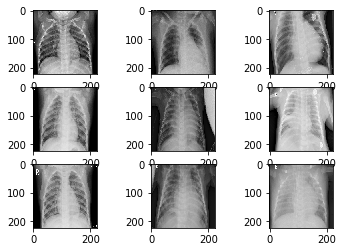

In [ ]:
for X_batch, y_batch in aug.flow(trainX, trainY, batch_size=9):
	# create a grid of 3x3 images
	for i in range(0, 9):
		plt.subplot(330 + 1 + i)
		plt.imshow(X_batch[i])
	# show the plot
	plt.show()
	break

As I started this analysis my goal was to learn the basics of deep learning for computer vision, as I said earlier I was following as a reference the dataset's top Kernel, so at first I was looking for a model that could simply come close to the results of the kernel that I was following as an example, that means NAIN's kernel, I only knew that it had to be a model built from scratch because I have to get the basics straight first, and from what I've seen fine tuning has already been done by a lot of other users and it would simply mean me copy-pasting more code from other kernels.


So here are the results I was trying to reach, these are NAIN's results:


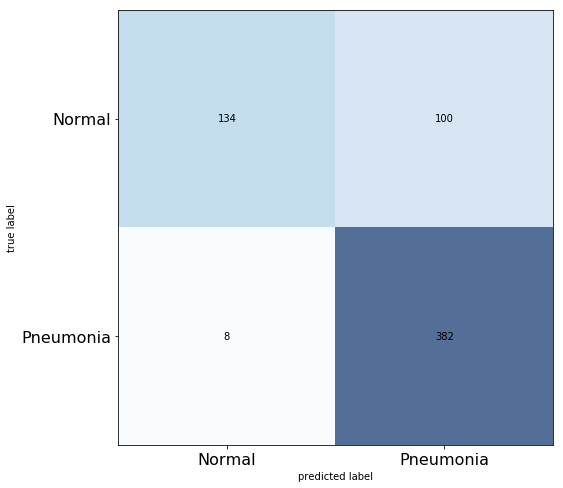

Recall of the model is 0.98

Precision of the model is 0.79


I started immediatly  building complex models with hundreds of neurons and stacking all sorts of layers (gaussian noise,  dropout, separable convs), and adding all kinds of data augmentation that would make the model take literally hours to train, that would consume all the RAM available on CoLab and make the system crash, and what's worse the results were very bad, the model would simply tend to classify most (and often even all) of the observations as "Pneunomia" and couldn't learn to recognize a healthy individual with precision.

So intead, I tried to build a very simple and basic model, that would be fast to train so I could tweak the architecture and hyperparameters more easily and see what would work and what not.

In [ ]:
EPOCHS =50
BS = 64

def build_model():
  input_img=Input(shape=(224,224,3), name='ImageInput')

  x = Conv2D(16, (3,3),activation='relu', padding='same', name='Conv1_1')(input_img)
  x = Conv2D(16, (3,3), activation='relu', padding='same', name='Conv1_2')(x)
  
  x = MaxPooling2D((2,2), name='pool1')(x)
  x = Conv2D(32, (3,3),activation='relu', padding='same', name='Conv2_1')(x)
  x = Conv2D(32, (3,3), activation='relu', padding='same', name='Conv2_2')(x)
  x = MaxPooling2D((2,2), name='pool2')(x)

  x = Flatten(name='flatten')(x)
  x = Dense(128, activation='relu', name='fc1')(x)
  x = Dense(64, activation='relu', name='fc2')(x)
  x = Dense(2, activation='softmax', name='fc3')(x)

  model = Model(inputs = input_img, output=x)
  return model

In [ ]:
model =  build_model()
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ImageInput (InputLayer)      (None, 224, 224, 3)       0         
_________________________________________________________________
Conv1_1 (Conv2D)             (None, 224, 224, 16)      448       
_________________________________________________________________
Conv1_2 (Conv2D)             (None, 224, 224, 16)      2320      
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 16)      0         
_________________________________________________________________
Conv2_1 (Conv2D)             (None, 112, 112, 32)      4640      
_________________________________________________________________
Conv2_2 (Conv2D)             (None, 112, 112, 32)      9248      
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 32)        0   

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("Im..., outputs=Tensor("fc...)`


I wasn't sure which metric was best to monitor, whether the validation loss or the validation accuracy so I monitored them both.

My models have no early stopping, so at the end of the training process for every model I'll check 3 different sets of weights on the test set:
  -the weights at the end of the last epoch
  -the weights with lowest validation loss
  -the weights with the highest validation accuracy
Of these three, I will further inspect only the predictions of the best one.

I think this would technically be considered not legitimate in a kaggle competion, since I'm actually using the test data as validation data, but I guess I could apply the same logic if the validation set was a bit larger and/or by using k-fold cross validation.

In [ ]:
opt = Adam(lr=0.0001, decay=1e-5)
chkpt = ModelCheckpoint(filepath='best_aug_model_todate2loss.h5',monitor='val_loss', save_best_only=True, save_weights_only=True)
chkpt2 = ModelCheckpoint(filepath='best_aug_model_todate2acc.h5',monitor='val_accuracy', save_best_only=True, save_weights_only=True)
callbacks_list=[chkpt,chkpt2]
model.compile(loss='binary_crossentropy', metrics=['accuracy'],optimizer=opt)

In [ ]:
H = model.fit_generator(aug.flow(trainX, trainY, batch_size=BS),callbacks=callbacks_list,
	validation_data=(valX, valY), steps_per_epoch=len(trainX) // BS,
	epochs=EPOCHS)

Epoch 1/50
81/81 [==============================] - 11s 141ms/step - loss: 0.3719 - accuracy: 0.8298 - val_loss: 0.8294 - val_accuracy: 0.6250
Epoch 2/50
81/81 [==============================] - 6s 79ms/step - loss: 0.1409 - accuracy: 0.9478 - val_loss: 0.6319 - val_accuracy: 0.6875
Epoch 3/50
81/81 [==============================] - 7s 83ms/step - loss: 0.0903 - accuracy: 0.9670 - val_loss: 0.1492 - val_accuracy: 0.9375
Epoch 4/50
81/81 [==============================] - 7s 80ms/step - loss: 0.0724 - accuracy: 0.9730 - val_loss: 0.1772 - val_accuracy: 0.9375
Epoch 5/50
81/81 [==============================] - 6s 80ms/step - loss: 0.0591 - accuracy: 0.9794 - val_loss: 1.0374 - val_accuracy: 0.6250
Epoch 6/50
81/81 [==============================] - 7s 81ms/step - loss: 0.0568 - accuracy: 0.9783 - val_loss: 0.2976 - val_accuracy: 0.8750
Epoch 7/50
81/81 [==============================] - 6s 79ms/step - loss: 0.0443 - accuracy: 0.9849 - val_loss: 0.0696 - val_accuracy: 1.0000
Epoch 8/50


dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


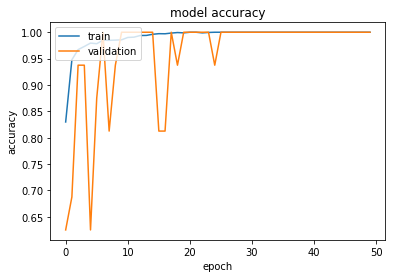

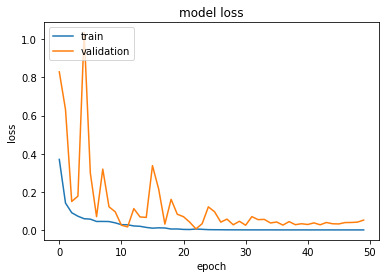

In [ ]:
print(H.history.keys())
#  "Accuracy"
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
model.save_weights("last_epoch.h5")

In [ ]:
test_loss_last, test_score_last = model.evaluate(testX, testY, batch_size=32)

624/624 [==============================] - 0s 733us/step


In [ ]:
print("Loss on test set: ", test_loss_last)
print("Accuracy on test set: ", test_score_last)

Loss on test set:  2.9588354306343274
Accuracy on test set:  0.7419871687889099


In [ ]:
model.load_weights("best_aug_model_todate2loss.h5")

In [ ]:
test_loss_bestloss, test_score_bestloss = model.evaluate(testX, testY, batch_size=32)

624/624 [==============================] - 0s 633us/step


In [ ]:
print("Loss on test set: ", test_loss_bestloss)
print("Accuracy on test set: ", test_score_bestloss)

Loss on test set:  1.4866247391089416
Accuracy on test set:  0.7836538553237915


In [ ]:
model.load_weights("best_aug_model_todate2acc.h5")

In [ ]:
test_loss_bestacc, test_score_bestacc = model.evaluate(testX, testY, batch_size=32)

624/624 [==============================] - 0s 640us/step


In [ ]:
print("Loss on test set: ", test_loss_bestacc)
print("Accuracy on test set: ", test_score_bestacc)

Loss on test set:  0.9043516379136306
Accuracy on test set:  0.7788461446762085


In [ ]:
max_model=np.argmax([test_score_last,test_score_bestloss,test_score_bestacc])
max_model

1

In [ ]:
if max_model == 0:
    model.load_weights("last_epoch.h5")
elif max_model == 1:
    model.load_weights("best_aug_model_todate2loss.h5")
elif max_model == 2:
    model.load_weights("best_aug_model_todate2acc.h5") 
    
    
    

In [ ]:
# Get predictions
preds = model.predict(testX, batch_size=16)
preds = np.argmax(preds, axis=-1)

# Original labels
orig_test_labels = np.argmax(testY, axis=-1)

print(orig_test_labels.shape)
print(preds.shape)

(624,)
(624,)


<Figure size 432x288 with 0 Axes>

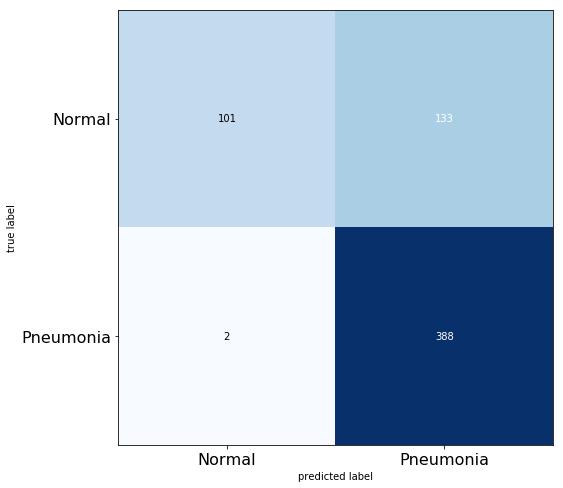

In [ ]:
# Get the confusion matrix
cm  = confusion_matrix(orig_test_labels, preds)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.show()

In [ ]:
print(classification_report(orig_test_labels, preds))

              precision    recall  f1-score   support

           0       0.98      0.43      0.60       234
           1       0.74      0.99      0.85       390

    accuracy                           0.78       624
   macro avg       0.86      0.71      0.73       624
weighted avg       0.83      0.78      0.76       624



As you can see from the confusion matrix and the precision/recall report the model catches the vast majority of the patients with pneunomia (recall), but around a quarter of those diagnosed with pneunomia are actually healthy people (precision).
This happens because the model can't precisely distinguish healthy from non-healthy individuals so it simply classifies them as "Pneunomia" whenever in doubt.

When the model encounters a healthy individual it seems to basically pick up a diagnosis at random by tossing a coin.

My model was very basic and there was no data augmentation so nobody was expecting state of the art results, I showed you this model for a reason though, next I try and apply some zoom augmentation to the data, let's see what happens.

In [ ]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator(zoom_range=[0.9,1.1],
                         #brightness_range=[0.,1.]
                         #horizontal_flip=True ,
                         #rotation_range=90,
                         #height_shift_range=0.15,
                         #width_shift_range=[-0.125,0.125]
                         )
aug.fit(trainX)

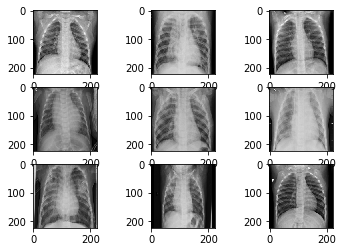

In [ ]:
for X_batch, y_batch in aug.flow(trainX, trainY, batch_size=9):
	# create a grid of 3x3 images
	for i in range(0, 9):
		plt.subplot(330 + 1 + i)
		plt.imshow(X_batch[i])
	# show the plot
	plt.show()
	break

In [ ]:
EPOCHS =50
BS = 64

def build_model():
  input_img=Input(shape=(224,224,3), name='ImageInput')

  x = Conv2D(16, (3,3),activation='relu', padding='same', name='Conv1_1')(input_img)
  x = Conv2D(16, (3,3), activation='relu', padding='same', name='Conv1_2')(x)
  x = MaxPooling2D((2,2), name='pool1')(x)

  x = Conv2D(32, (3,3),activation='relu', padding='same', name='Conv2_1')(x)
  x = Conv2D(32, (3,3), activation='relu', padding='same', name='Conv2_2')(x)
  x = MaxPooling2D((2,2), name='pool2')(x)

  x = Flatten(name='flatten')(x)
  x = Dense(128, activation='relu', name='fc1')(x)
  x = Dense(64, activation='relu', name='fc2')(x)
  x = Dense(2, activation='softmax', name='fc3')(x)

  model = Model(inputs = input_img, output=x)
  return model

In [ ]:
model =  build_model()
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ImageInput (InputLayer)      (None, 224, 224, 3)       0         
_________________________________________________________________
Conv1_1 (Conv2D)             (None, 224, 224, 16)      448       
_________________________________________________________________
Conv1_2 (Conv2D)             (None, 224, 224, 16)      2320      
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 16)      0         
_________________________________________________________________
Conv2_1 (Conv2D)             (None, 112, 112, 32)      4640      
_________________________________________________________________
Conv2_2 (Conv2D)             (None, 112, 112, 32)      9248      
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 32)        0   

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("Im..., outputs=Tensor("fc...)`


In [ ]:
opt = Adam(lr=0.0001, decay=1e-5)
chkpt = ModelCheckpoint(filepath='best_aug_model_todate2loss.h5',monitor='val_loss', save_best_only=True, save_weights_only=True)
chkpt2 = ModelCheckpoint(filepath='best_aug_model_todate2acc.h5',monitor='val_accuracy', save_best_only=True, save_weights_only=True)
callbacks_list=[chkpt,chkpt2]
model.compile(loss='binary_crossentropy', metrics=['accuracy'],optimizer=opt)

In [ ]:
H = model.fit_generator(aug.flow(trainX, trainY, batch_size=BS),callbacks=callbacks_list,
	validation_data=(valX, valY), steps_per_epoch=len(trainX) // BS,
	epochs=EPOCHS)

Epoch 1/50
81/81 [==============================] - 50s 617ms/step - loss: 0.4171 - accuracy: 0.8146 - val_loss: 1.2289 - val_accuracy: 0.6250
Epoch 2/50
81/81 [==============================] - 49s 601ms/step - loss: 0.1713 - accuracy: 0.9340 - val_loss: 0.5883 - val_accuracy: 0.6875
Epoch 3/50
81/81 [==============================] - 50s 611ms/step - loss: 0.1257 - accuracy: 0.9544 - val_loss: 0.9610 - val_accuracy: 0.6875
Epoch 4/50
81/81 [==============================] - 50s 614ms/step - loss: 0.1357 - accuracy: 0.9466 - val_loss: 0.5080 - val_accuracy: 0.7500
Epoch 5/50
81/81 [==============================] - 51s 631ms/step - loss: 0.1041 - accuracy: 0.9629 - val_loss: 0.4325 - val_accuracy: 0.8125
Epoch 6/50
81/81 [==============================] - 50s 616ms/step - loss: 0.1240 - accuracy: 0.9544 - val_loss: 0.6778 - val_accuracy: 0.7500
Epoch 7/50
81/81 [==============================] - 50s 612ms/step - loss: 0.1066 - accuracy: 0.9587 - val_loss: 0.4378 - val_accuracy: 0.7500

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


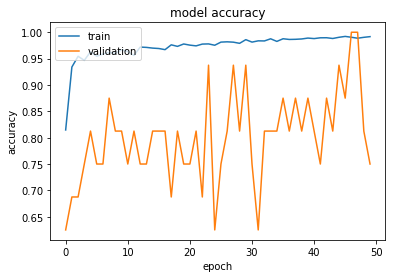

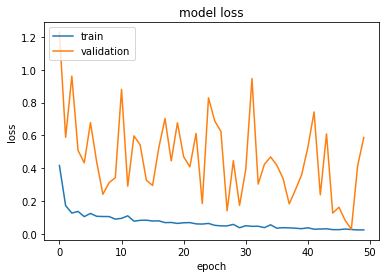

In [ ]:
print(H.history.keys())
#  "Accuracy"
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
model.save_weights("last_epoch.h5")

In [ ]:
test_loss_last, test_score_last = model.evaluate(testX, testY, batch_size=32)

624/624 [==============================] - 0s 638us/step


In [ ]:
print("Loss on test set: ", test_loss_last)
print("Accuracy on test set: ", test_score_last)

Loss on test set:  1.2146703677299695
Accuracy on test set:  0.8012820482254028


In [ ]:
model.load_weights("best_aug_model_todate2loss.h5")

In [ ]:
test_loss_bestloss, test_score_bestloss = model.evaluate(testX, testY, batch_size=32)

624/624 [==============================] - 0s 615us/step


In [ ]:
print("Loss on test set: ", test_loss_bestloss)
print("Accuracy on test set: ", test_score_bestloss)

Loss on test set:  0.6935016522422816
Accuracy on test set:  0.8782051205635071


In [ ]:
model.load_weights("best_aug_model_todate2acc.h5")

In [ ]:
test_loss_bestacc, test_score_bestacc = model.evaluate(testX, testY, batch_size=32)

624/624 [==============================] - 0s 610us/step


In [ ]:
print("Loss on test set: ", test_loss_bestacc)
print("Accuracy on test set: ", test_score_bestacc)

Loss on test set:  0.7687995053636723
Accuracy on test set:  0.870192289352417


In [ ]:
max_model=np.argmax([test_score_last,test_score_bestloss,test_score_bestacc])
max_model

1

In [ ]:
if max_model == 0:
    model.load_weights("last_epoch.h5")
elif max_model == 1:
    model.load_weights("best_aug_model_todate2loss.h5")
elif max_model == 2:
    model.load_weights("best_aug_model_todate2acc.h5")
    
    
    

In [ ]:
# Get predictions
preds = model.predict(testX, batch_size=16)
preds = np.argmax(preds, axis=-1)

# Original labels
orig_test_labels = np.argmax(testY, axis=-1)

print(orig_test_labels.shape)
print(preds.shape)

(624,)
(624,)


<Figure size 432x288 with 0 Axes>

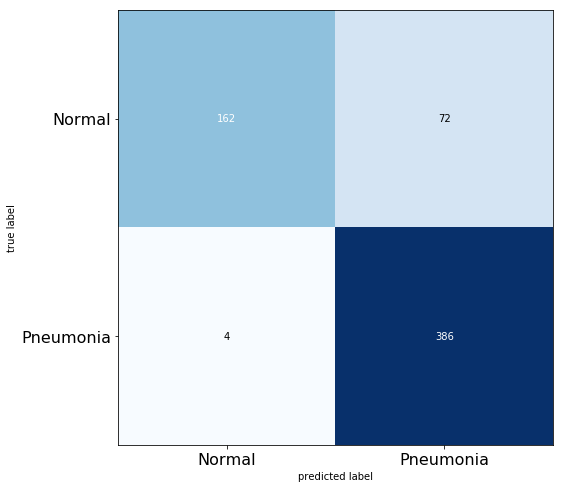

In [ ]:
# Get the confusion matrix
cm  = confusion_matrix(orig_test_labels, preds)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.show()

In [ ]:
print(classification_report(orig_test_labels, preds))

              precision    recall  f1-score   support

           0       0.98      0.69      0.81       234
           1       0.84      0.99      0.91       390

    accuracy                           0.88       624
   macro avg       0.91      0.84      0.86       624
weighted avg       0.89      0.88      0.87       624



As you can see just by randomly zooming in/out images by at most 10% has drastically improved the results.
Now the model has a clearer view of the 2 groups of data, although there are still a lot of individuals wrongfully diagnosticated with pneunomia.

I made a lot of tries and in my experience the following should be the (approximate) optimal zoom-range, adding too much zooming seemed to be disruptive.

In [ ]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator(zoom_range=[0.75,1.25],
                         #brightness_range=[0.,1.]
                         #horizontal_flip=True ,
                         #rotation_range=90,
                         #height_shift_range=0.15,
                         #width_shift_range=[-0.125,0.125]
                         )
aug.fit(trainX)

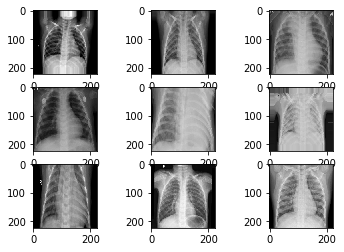

In [ ]:
for X_batch, y_batch in aug.flow(trainX, trainY, batch_size=9):
	# create a grid of 3x3 images
	for i in range(0, 9):
		plt.subplot(330 + 1 + i)
		plt.imshow(X_batch[i])
	# show the plot
	plt.show()
	break

I prolong the training to 100 epochs because by experience it generally takes a bit more than 50 before it starts overfitting.

In [ ]:
EPOCHS =100
BS = 64

def build_model():
  input_img=Input(shape=(224,224,3), name='ImageInput')

  x = Conv2D(16, (3,3),activation='relu', padding='same', name='Conv1_1')(input_img)
  x = Conv2D(16, (3,3), activation='relu', padding='same', name='Conv1_2')(x)
  x = MaxPooling2D((2,2), name='pool1')(x)

  x = Conv2D(32, (3,3),activation='relu', padding='same', name='Conv2_1')(x)
  x = Conv2D(32, (3,3), activation='relu', padding='same', name='Conv2_2')(x)
  x = MaxPooling2D((2,2), name='pool2')(x)

  x = Flatten(name='flatten')(x)
  x = Dense(128, activation='relu', name='fc1')(x)
  x = Dense(64, activation='relu', name='fc2')(x)
  x = Dense(2, activation='softmax', name='fc3')(x)

  model = Model(inputs = input_img, output=x)
  return model

In [ ]:
model =  build_model()
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ImageInput (InputLayer)      (None, 224, 224, 3)       0         
_________________________________________________________________
Conv1_1 (Conv2D)             (None, 224, 224, 16)      448       
_________________________________________________________________
Conv1_2 (Conv2D)             (None, 224, 224, 16)      2320      
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 16)      0         
_________________________________________________________________
Conv2_1 (Conv2D)             (None, 112, 112, 32)      4640      
_________________________________________________________________
Conv2_2 (Conv2D)             (None, 112, 112, 32)      9248      
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 32)        0   

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("Im..., outputs=Tensor("fc...)`


In [ ]:
opt = Adam(lr=0.0001, decay=1e-5)
chkpt = ModelCheckpoint(filepath='best_aug_model_todate2loss.h5',monitor='val_loss', save_best_only=True, save_weights_only=True)
chkpt2 = ModelCheckpoint(filepath='best_aug_model_todate2acc.h5',monitor='val_accuracy', save_best_only=True, save_weights_only=True)
callbacks_list=[chkpt,chkpt2]
model.compile(loss='binary_crossentropy', metrics=['accuracy'],optimizer=opt)

In [ ]:
H = model.fit_generator(aug.flow(trainX, trainY, batch_size=BS),callbacks=callbacks_list,
	validation_data=(valX, valY), steps_per_epoch=len(trainX) // BS,
	epochs=EPOCHS)

Epoch 1/100
81/81 [==============================] - 50s 617ms/step - loss: 0.4175 - accuracy: 0.8183 - val_loss: 0.4199 - val_accuracy: 0.8125
Epoch 2/100
81/81 [==============================] - 49s 605ms/step - loss: 0.2369 - accuracy: 0.9014 - val_loss: 1.1029 - val_accuracy: 0.6250
Epoch 3/100
81/81 [==============================] - 49s 608ms/step - loss: 0.2029 - accuracy: 0.9173 - val_loss: 0.9062 - val_accuracy: 0.6250
Epoch 4/100
81/81 [==============================] - 48s 596ms/step - loss: 0.1816 - accuracy: 0.9325 - val_loss: 0.6270 - val_accuracy: 0.6875
Epoch 5/100
81/81 [==============================] - 49s 607ms/step - loss: 0.1792 - accuracy: 0.9330 - val_loss: 0.6120 - val_accuracy: 0.6875
Epoch 6/100
81/81 [==============================] - 50s 613ms/step - loss: 0.1551 - accuracy: 0.9429 - val_loss: 0.7731 - val_accuracy: 0.6875
Epoch 7/100
81/81 [==============================] - 49s 607ms/step - loss: 0.1747 - accuracy: 0.9342 - val_loss: 0.9912 - val_accuracy:

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


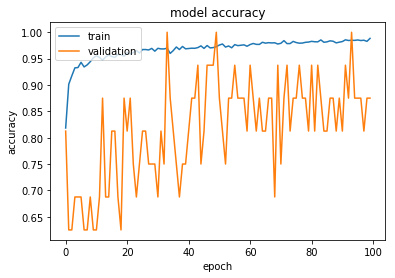

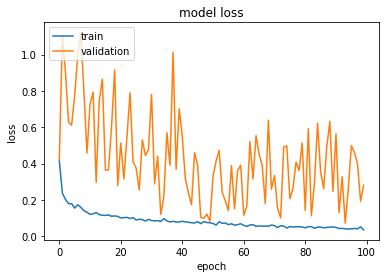

In [ ]:
print(H.history.keys())
#  "Accuracy"
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
model.save_weights("last_epoch.h5")

In [ ]:
test_loss_last, test_score_last = model.evaluate(testX, testY, batch_size=32)

624/624 [==============================] - 0s 641us/step


In [ ]:
print("Loss on test set: ", test_loss_last)
print("Accuracy on test set: ", test_score_last)

Loss on test set:  0.44299774234875655
Accuracy on test set:  0.9134615659713745


In [ ]:
model.load_weights("best_aug_model_todate2loss.h5")

In [ ]:
test_loss_bestloss, test_score_bestloss = model.evaluate(testX, testY, batch_size=32)

624/624 [==============================] - 0s 589us/step


In [ ]:
print("Loss on test set: ", test_loss_bestloss)
print("Accuracy on test set: ", test_score_bestloss)

Loss on test set:  0.35491314664100987
Accuracy on test set:  0.9086538553237915


In [ ]:
model.load_weights("best_aug_model_todate2acc.h5")

In [ ]:
test_loss_bestacc, test_score_bestacc = model.evaluate(testX, testY, batch_size=32)

624/624 [==============================] - 0s 572us/step


In [ ]:
print("Loss on test set: ", test_loss_bestacc)
print("Accuracy on test set: ", test_score_bestacc)

Loss on test set:  0.24384221052512145
Accuracy on test set:  0.9150640964508057


In [ ]:
max_model=np.argmax([test_score_last,test_score_bestloss,test_score_bestacc])
max_model

2

In [ ]:
if max_model == 0:
    model.load_weights("last_epoch.h5")
elif max_model == 1:
    model.load_weights("best_aug_model_todate2loss.h5")
elif max_model == 2:
    model.load_weights("best_aug_model_todate2acc.h5")

In [ ]:
# Get predictions
preds = model.predict(testX, batch_size=16)
preds = np.argmax(preds, axis=-1)

# Original labels
orig_test_labels = np.argmax(testY, axis=-1)

print(orig_test_labels.shape)
print(preds.shape)

(624,)
(624,)


<Figure size 432x288 with 0 Axes>

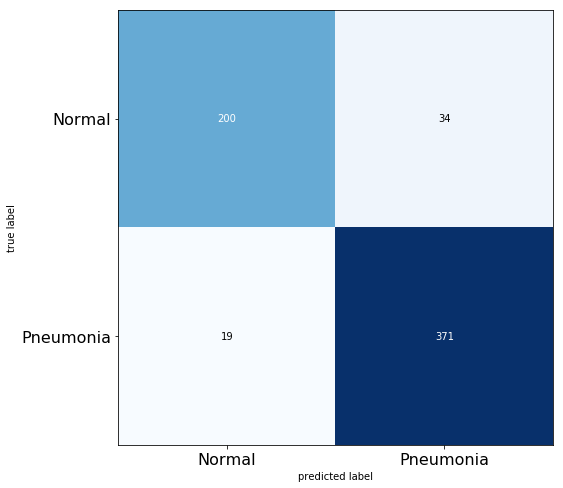

In [ ]:
# Get the confusion matrix
cm  = confusion_matrix(orig_test_labels, preds)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.show()

In [ ]:
print(classification_report(orig_test_labels, preds))

              precision    recall  f1-score   support

           0       0.91      0.85      0.88       234
           1       0.92      0.95      0.93       390

    accuracy                           0.92       624
   macro avg       0.91      0.90      0.91       624
weighted avg       0.91      0.92      0.91       624



So this is the best model I've been able to find so far, neural networks are stochastic of course so you might get different results by running the same code, I've tried training it several times the highest test score I've seen was 94.30%...seems to be pretty accurate, not sure if it's up to medical standards though.

Thank you for going through my first computer vision challange, I hope you found it useful.